# Ajuste de hiperparámetros
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp; **Revisor:** Beatriz Pontes   &nbsp;&nbsp;&nbsp; **Última modificación:** 28/01/2019

## Contenido

1. <a href="#clasificacion">Ajuste de parámetros para clasificación</a> <br>
    1.1 <a href="#logistica">Regresión Logística</a> <br>
    1.2 <a href="#RF">Random Forest</a><br>
2. <a href="#regresion">Ajuste de parámetros para regresión</a> <br>
    2.1 <a href="#lasso">Lasso</a><br>
    2.2 <a href="#ridge">Ridge</a><br>
    2.3 <a href="#RFR">Random Forest Regressor</a>
------------------------------------------------------

En este notebook veremos los instrumentos que proporciona Sklearn para buscar una buena configuración de parámetros para un determinado estimador. Trabajaremos con los mismos datasets que en los respectivos notebooks de clasificación y regresión. Para cada tarea usaremos los siguientes estimadores:

- Clasificación:
    - Regresión Logística
    - _Random Forest_
- Regresión:
    - Regresión lineal con regularización 'l1' (Lasso)
    - Regresión lineal con regularización 'l2' (Ridge)
    - _Random Forest_

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Usaremos la clase <code>GridSearchCV</code> para realizar una búsqueda exhaustiva del espacion de parámetros que definamos en cada caso. El esquema que seguiremos será el que se muestra en el siguiente fragmento para un clasificador basado en máquinas soporte:
<code>
      parametros = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
      clasificador = SVC()
      grid = GridSearchCV(clasificador, parametros)
      grid.fit(X,y)
</code>
Para cada estimador debemos comprender el significado de los parámetros más importantes, y definir una buena combinación de posibles valores para ellos.

Dependiendo del estimador y del número de valores para los parámetros, la búsqueda puede ser más o menos costosa computacionalmente, pudiéndose llegar a experimentos que requieran horas o incluso días.

La siguiente celda incluye un par de funciones que nos permitirán visualizar el resultado de la exploración de los espacios de parámetros con los que trabajaremos:

In [2]:
def muestra_evolucion_un_parametro(grid, parametro):
    ''' Muestra la evolución de los resultados de gridsearch en función de un parámetro 
    '''
    # Volcamos los resultados en un dataframe y seleccionamos la columna del parámetro a visualizar
    valores_params = pd.DataFrame(list(grid.cv_results_['params']))[parametro]
    
    # Creamos una serie con los resultados y usando como índice los valores del parámetro
    resultados = pd.Series(grid.cv_results_['mean_test_score'], index=valores_params)
    resultados.plot()
    

def muestra_evolucion_dos_parametros(grid, parametros):
    ''' Muestra la evolución de los resultados de gridsearch en función de un parámetro 
    '''
    # Volcamos los resultados en un dataframe y seleccionamos las columnas de los parámetros a visualizar
    valores_params = pd.DataFrame(list(grid.cv_results_['params']))[parametros]
    
    # Creamos un DataFrame con tres columnas: los resultados y los valores de los dos paráemtros
    resultados = pd.DataFrame(list(grid.cv_results_['mean_test_score']), columns=['resultados'])
    resultados = pd.concat([resultados, valores_params], axis=1)
    
    # Creamos una tabla pivot a partir de losn resultados y la visualizamos
    tabla = resultados.pivot_table(index=parametros[0], columns=parametros[1], values='resultados', fill_value=0)
    sns.heatmap(tabla, annot=True, fmt='.4f', cmap='Greens')
    plt.show()

## 1. Ajuste de parámetros para clasificación <a name="clasificacion"> </a>

Usaremos el dataset _breast-cancer_, disponible en Sklearn que tiene:
- 569 instancias
- 30 atributos numéricos

In [3]:
# Lectura del dataset desde Sklearn y creación de 'X' e 'y'
datos = load_breast_cancer()
X = pd.DataFrame(datos['data'], columns=datos['feature_names'])
y = pd.Series(datos['target'])
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

### 1.1. Regresión Logística <a name="logistica"> </a>

Usa una función de enlace _logística_ para predecir la probabilidad de pertenecer, o no, a una clase. El uso de dicha función permite convertir el problema de calcular dicha probabilidad en un problema de regresión lineal.

Hiperparámetros con los que trabajaremos:
- <code>penalty</code>: función de regularización (puede ser <code>l1</code> o <code>l2</code>)
- <code>C</code>: mide el inverso de la influencia del factor de regularización
- <code>fit_intercept</code>: puede ser <code>False</code> (fuerza que la recta pase por el origen de coordenadas) o <code>True</code> (permite que la recta corte el eje y en un punto distinto a 0)
- <code>solver</code>: técnica usada para calcular los coeficientes puede tomar los valores <code> ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']</code>. La mayoría solo se pueden usar con <code>l2</code>.

In [5]:
# EJERCICIO: evaluar mediante validación cruzada (cv=5) un clasificador de Regresión Logística con los parámetros por defecto. Mostrar:
#    - Los valores de los parámetros por defecto
#    - El resultado de la evaluación

classifier = LogisticRegression()
print(classificador)
scores = cross_val_score(classifier, X, y, cv=5)
scores

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([0.93043478, 0.93913043, 0.97345133, 0.94690265, 0.96460177])

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


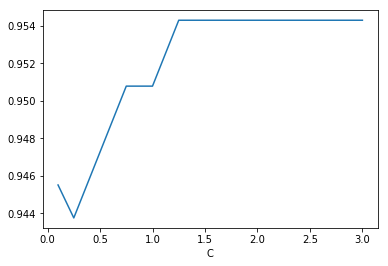

In [21]:
# EJERCICIO: probar distintos valores del parámetro 'C' para Regresión Logística. Mostrar:
#    - El mejor resultado
#    - El valor del parámetro para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función del valor del parámetro
param={'C':[0.1,0.25,0.5,0.75,1,1.25,1.75,2.5,3]}
grid = GridSearchCV(classifier,param,cv=5)
grid.fit(X,y)
scores = [x[1] for x in grid.grid_scores_]
muestra_evolucion_un_parametro(grid, 'C')

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


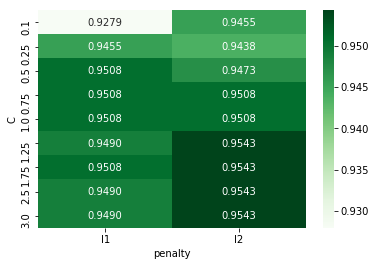

In [26]:
# EJERCICIO: probar distintos valores de los parámetros 'C' y 'penalty' para Regresión Logística. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función de los valores de los dos parámetros
param={'C':[0.1,0.25,0.5,0.75,1,1.25,1.75,2.5,3], 'penalty':['l1','l2']}
grid = GridSearchCV(classifier,param,cv=5)
grid.fit(X,y)
scores = [x[1] for x in grid.grid_scores_]
muestra_evolucion_dos_parametros(grid, list(param.keys()))

In [29]:
# EJERCICIO: probar distintos valores de los parámetros 'C', 'fit_intercept' y 'penalty' para Regresión Logística. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado
#    - Gráficas que comparen dos a dos la evolución de los resultados en función de los parámetros 
#      (se agregan con la media todos los resultados que se obtienen al variar el tercer parámetro)
param={'C':[0.1,0.25,0.5,0.75,1,1.25,1.75,2.5,3], 'penalty':['l1','l2'], 'fit_intercept':[True,False]}
grid = GridSearchCV(classifier,param,cv=5)
grid.fit(X,y)
scores = [x[1] for x in grid.grid_scores_]
grid.best_params_

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'C': 1.25, 'fit_intercept': True, 'penalty': 'l2'}

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: Convergence

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: Convergence

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: Convergence

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: Convergence

/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pedrolarben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: Convergence

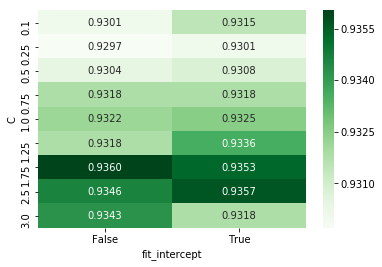

{'C': 1.75, 'fit_intercept': True, 'solver': 'newton-cg'}

In [30]:
# EJERCICIO: probar distintos valores de los parámetros 'C', 'fit_intercept' y 'solver':
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado
param={'C':[0.1,0.25,0.5,0.75,1,1.25,1.75,2.5,3], 'fit_intercept':[True,False], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(classifier,param,cv=5)
grid.fit(X,y)
scores = [x[1] for x in grid.grid_scores_]
muestra_evolucion_dos_parametros(grid, list(param.keys()))
grid.best_params_

### 1.2. _Random Forest_ <a name="RF"> </a>

Técnica _ensemble_ que entrena varios árboles de decisión a partir de muestreos. En concreto, para cada árbol se eligen:
- Distintas muestras de instancias. Se aplica reemplazo para que los tamaños de los datasets sean siempre iguales.
- Distintos conjuntos de atributos
En la clasificación, el valor final de la predicción se calcula con la moda de las salidas generadas por todos los árboles.

Hiperparámetros con los que trabajaremos:
- <code>n_estimators</code>: número de árboles que se entrenan
- <code>criterion</code>: técnica elegida para medir la calidad de un _split_ (puede ser <code>gini</code> o <code>entropy</code>)
- <code>max_depth</code>: la profundidad máxima de los árboles
- <code>max_features</code>: el número de atributos que se tienen en cuenta al buscar el mejor _split_ de un árbol
- <code>min_samples_split</code>: número mínimo de muestras para hacer un _split_ en un árbol
- <code>min_samples_leaf</code>: número mínimo de muestras para consolidar una hoja en el árbol
- <code>bootstrap</code>: puede ser <code>False</code> (no se aplica _bootstraping_ en el reemplazo) o <code>True</code> (sí se aplica). Suele funcionar mejor con <code>True</code>


In [36]:
# EJERCICIO: evaluar mediante validación cruzada (cv=5) un clasificador Random Forest con los parámetros por defecto. Mostrar:
#    - Los valores de los parámetros por defecto
#    - El resultado de la evaluación
clf = RandomForestClassifier()
param={'n_estimators':[5,9,50,100], 'criterion':['gini', 'entropy'], 'max_depth':[3,6,9], 'max_features':[3,6,9], 'min_samples_split':[2,3], 'min_samples_leaf':[1,2,3], 'bootstrap':[True,False] }
grid = GridSearchCV(clf,param,cv=5,n_jobs=-1)
grid.fit(X,y)
#muestra_evolucion_dos_parametros(grid, list(param.keys())[0:2])
grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50}

In [ ]:
# EJERCICIO: probar distintos valores del parámetro 'n_estimators' del clasificador Random Forest. Mostrar:
#    - El mejor resultado
#    - El valor del parámetro para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función del valor del parámetro


In [ ]:
# EJERCICIO: probar distintos valores de todos los parámetros del clasificador Random Forest. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado


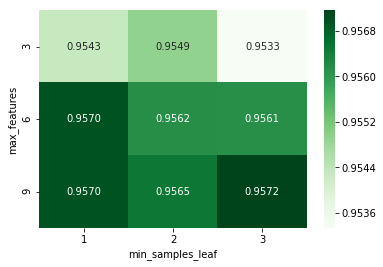

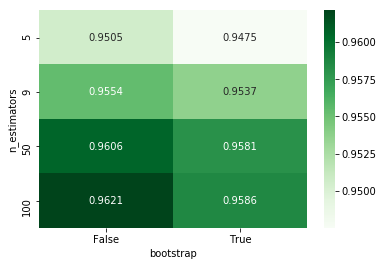

In [37]:
# EJERCICIO: mostrar gráficas que comparen dos a dos la evolución de los resultados en función de algunos parámetros 
muestra_evolucion_dos_parametros(grid, ['max_features', 'min_samples_leaf'])
muestra_evolucion_dos_parametros(grid, ['n_estimators', 'bootstrap'])

## 2. Ajuste de parámetros para regresión <a name="regresion"> </a>

Usaremos el dataset _concrete_, disponible en el repositorio UCI que tiene:
- 1030 instancias
- 8 atributos numéricos

In [ ]:
# Lectura del dataset 'concrete.csv' y creación de 'X' e 'y'
datos = pd.read_csv('./concrete.csv')
y = datos['Concrete compressive strength']
X = datos.drop(['Concrete compressive strength'], axis=1)
print(X.info())
print(y[:10])

### 2.1. Lasso (regularización 'l1') <a name="lasso"> </a>

Regresión lineal con regularización basada en la norma 1. El objetivo es minimizar la siguiente función objetivo:
$$
(1 / (2 * n\_samples)) * ||y - Xw||^2_2 + \alpha * ||w||_1
$$

Hiperparámetros con los que trabajaremos:
- <code>alpha</code>: mide la influencia del factor de regularización
- <code>fit_intercept</code>: puede ser <code>False</code> (fuerza que la recta pase por el origen de coordenadas) o <code>True</code> (permite que la recta corte el eje y en un punto distinto a 0) 
- <code>normalize</code>: puede ser <code>False</code> (deja la matriz X sin cambios) o <code>True</code> (normaliza la matriz X)

In [ ]:
# EJERCICIO: evaluar mediante validación cruzada (cv=5) un regresor Lasso con los parámetros por defecto. Mostrar:
#    - Los valores de los parámetros por defecto
#    - El resultado de la evaluación


In [ ]:
# EJERCICIO: probar distintos valores del parámetro 'alpha' del regresor Lasso. Mostrar:
#    - El mejor resultado
#    - El valor del parámetro para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función del valor del parámetro


In [ ]:
# EJERCICIO: probar distintos valores de los parámetros 'alpha' y 'fit_intercept' del regresor Lasso. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función de los valores de los dos parámetros


In [ ]:
# EJERCICIO: probar distintos valores de los parámetros 'alpha', 'fit_intercept' y 'normalize' del regresor Lasso. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado
#    - Gráficas que comparen dos a dos la evolución de los resultados en función de los parámetros 
clf = RandomForestClassifier()
param={'n_estimators':[5,9,50,100], 'criterion':['gini', 'entropy'], 'max_depth':[3,6,9], 'max_features':[3,6,9], 'min_samples_split':[2,3], 'min_samples_leaf':[1,2,3], 'bootstrap':[True,False] }
grid = GridSearchCV(clf,param,cv=5,n_jobs=-1)
grid.fit(X,y)
#muestra_evolucion_dos_parametros(grid, list(param.keys())[0:2])
grid.best_params_

### 2.2. Ridge (regularización 'l2') <a name="ridge"> </a>
Regresión lineal con regularización basada en la norma 2. El objetivo es minimizar la siguiente función objetivo:
$$
||y - Xw||^2_2 + \alpha * ||w||^2_2
$$

Hiperparámetros con los que trabajaremos:
- <code>alpha</code>: mide la influencia del factor de regularización
- <code>fit_intercept</code>: puede ser <code>False</code> (fuerza que la recta pase por el origen de coordenadas) o <code>True</code> (permite que la recta corte el eje y en un punto distinto a 0)
- <code>normalize</code>: puede ser <code>False</code> (deja la matriz X sin cambios) o <code>True</code> (normaliza la matriz X)
- <code>solver</code>: técnica usada para calcular los coeficientes puede tomar los valores <code> ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']</code>

In [ ]:
# EJERCICIO: evaluar mediante validación cruzada (cv=5) un regresor Ridge con los parámetros por defecto. Mostrar:
#    - Los valores de los parámetros por defecto
#    - El resultado de la evaluación


In [ ]:
# EJERCICIO: probar distintos valores del parámetro 'alpha' del regresor Ridge. Mostrar:
#    - El mejor resultado
#    - El valor del parámetro para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función del valor del parámetro


In [ ]:
# EJERCICIO: probar distintos valores de todos los parámetros del regresor Ridge. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado


In [ ]:
# EJERCICIO: mostrar gráficas que comparen dos a dos la evolución de los resultados en función de algunos parámetros 


### 2.3.  _Random Forest Regressor_ <a name="RFR"> </a>

Técnica _ensemble_ que entrena varios árboles de decisión a partir de muestreos. En concreto, para cada árbol se eligen:
- Distintas muestras de instancias. Se aplica reemplazo para que los tamaños de los datasets sean siempre iguales.
- Distintos conjuntos de atributos
En la regresión, el valor final de la predicción se calcula con la media de las salidas generadas por todos los árboles.

Hiperparámetros con los que trabajaremos:
- <code>n_estimators</code>: número de árboles que se entrenan
- <code>criterion</code>: técnica elegida para medir la calidad de un _split_ (puede ser <code>mse</code> o <code>mae</code>)
- <code>max_depth</code>: la profundidad máxima de los árboles
- <code>max_features</code>: el número de atributos que se tienen en cuenta al buscar el mejor _split_ de un árbol
- <code>min_samples_split</code>: número mínimo de muestras para hacer un _split_ en un árbol
- <code>min_samples_leaf</code>: número mínimo de muestras para consolidar una hoja en el árbol
- <code>bootstrap</code>: puede ser <code>False</code> (no se aplica _bootstraping_ en el reemplazo) o <code>True</code> (sí se aplica). Suele funcionar mejor con <code>True</code>


In [ ]:
# EJERCICIO: evaluar mediante validación cruzada (cv=5) un regresor Random Forest con los parámetros por defecto. Mostrar:
#    - Los valores de los parámetros por defecto
#    - El resultado de la evaluación


In [ ]:
# EJERCICIO: probar distintos valores del parámetro 'n_estimators' del regresor Random Forest. Mostrar:
#    - El mejor resultado
#    - El valor del parámetro para el mejor resultado
#    - Una gráfica con la evolución de los resultados en función del valor del parámetro


In [ ]:
# EJERCICIO: probar distintos valores de todos los parámetros del regresor Random Forest. Mostrar:
#    - El mejor resultado
#    - El valor de los parámetros para el mejor resultado


In [ ]:
# EJERCICIO: mostrar gráficas que comparen dos a dos la evolución de los resultados en función de algunos parámetros 
